In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from kline import Kline
from  bt_base import tools

conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
# hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
hf=HKFuture()
begin='2011-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
df=hf.get_bars('HSI1201',_fields)
df.head()

OK


,datetime,code,open,high,low,close,trade_date
datetime,,,,,,,
2011-11-30 09:15:00,2011-11-30 09:15:00,HSI1201,18157.0,18157.0,18113.0,18113.0,2011-11-30
2011-11-30 09:17:00,2011-11-30 09:17:00,HSI1201,18131.0,18131.0,18130.0,18130.0,2011-11-30
2011-11-30 09:19:00,2011-11-30 09:19:00,HSI1201,18140.0,18140.0,18140.0,18140.0,2011-11-30
2011-11-30 09:21:00,2011-11-30 09:21:00,HSI1201,18127.0,18127.0,18115.0,18115.0,2011-11-30
2011-11-30 09:28:00,2011-11-30 09:28:00,HSI1201,18107.0,18107.0,18107.0,18107.0,2011-11-30


In [2]:
from bt_base import BT_Calc
class BT_Trade(BT_Calc):
#初始化---------------------------------------------------------------------------------
    def __init__(self,hf:HKFuture,index='HSI',**arg):
        self.hf=hf
        self._DateList=hf.get_main_contract_trade_dates(index)
        self.Test_Trade=True
        self.std_base=2.5
        self.cls()
        self.trade_para()
        print("---init-----")
#交易参数---------------------------------------------------------------
    def trade_para(self):
        pass
#每个交易日每条记录循环部分(只计算)---------------------------------------------------------
    def day_loop(self):
        self.day_calc_init()
        self.day_trade_init()
        df=self._para['df1']
        self._para['day_no']=0
        for i,row in df.iterrows():
            self._para['row']=row
            self.day_calc_main()
            self.day_trade_main()
            self._para['day_no']+=1
        self.day_calc_end()
        self.day_trade_end()

#每个交易日交易前初始化--------------------------------------------------------------------------
    def day_trade_init(self):
        pass

#每个交易日交易计算主体--------------------------------------------------------------------------
    def day_trade_main(self):
        pass

#每个交易日交易每天结束--------------------------------------------------------------------------
    def day_trade_end(self):
        pass
    
print("BT_Trade")

BT_Trade


In [12]:
class BT_Trade_STD(BT_Trade):
#交易参数---------------------------------------------------------------
    def trade_para(self):
        self._para['trade_state']='ready'
        self.MA60_NO=0
        self.std_base=2.5
        self.Stop_Ratio=1
        self.Trade_Cont='ma60_up'
        
#每个交易日交易前初始化--------------------------------------------------------------------------
    def day_trade_init(self):
        self._para['trade_state']='ready'
        self._trade={}
        
#每个交易日交易计算主体--------------------------------------------------------------------------
    def day_trade_main(self):
        if self._para['trade_state']=='ready':
            self.day_trade_open()
        elif self._para['trade_state']=='open':
             self.day_trade_close()
#开仓条件--------------------------------------------------------------------------
    def day_trade_open(self):
        if len(self._res['std'])==0:
            return
        row=self._para['row']
        std=self._res['std'][-1]
        cont={}
        #异动反弹至MA60
        cont['up2ma60']=[row['std1']>self.std_base , std['ma60_no']==self.MA60_NO , std['ma60_state']=='under']
        #异动回调至MA60
        cont['down2ma60']=[row['std1']<-self.std_base,std['ma60_no']==self.MA60_NO , std['ma60_state']=='over']
        #MA60异动上涨
        cont['ma60_up']=[row['std1']>self.std_base,std['ma60_no']==self.MA60_NO , std['ma60_state']=='over']
        #MA60异动下跌
        cont['ma60_down']=[row['std1']<-self.std_base , std['ma60_no']==self.MA60_NO , std['ma60_state']=='under']
        #自定义反转
        cont['short1']=[row['std1']>self.std_base , std['ma60_no']==self.MA60_NO , std['ma60_state']=='over']
        #自定义反转
        cont['long1']=[row['std1']<-self.std_base , std['ma60_no']==self.MA60_NO , std['ma60_state']=='under']
        
        if all(cont[self.Trade_Cont]):
            trade={}
            trade['open']=row['close']
            trade['open_row']=row
            trade['open_idx']=self._para['day_no']
            trade['open_dt']=row['datetime']
            trade['prod']=self._para['prod']
            trade['date']=self._para['date']
            if self.Trade_Cont in ['up2ma60','ma60_up','long1']:
                trade['direction']='long'
            else:
                trade['direction']='short'
            trade['ma60_idx']=std['ma60_idx']
            self._trade=trade
            self._para['trade_state']='open'
            
#平仓仓条件--------------------------------------------------------------------------
    def day_trade_close(self):
        trade=self._trade
        row=self._para['row']
        close_cont=self.ma60_no>self._trade['ma60_idx']
        if trade['direction']=='long':
            diff=trade['open_row']['close']-trade['open_row']['open']
            stop_price=trade['open_row']['low']-50*self.Stop_Ratio
            stop_price=trade['open']-50*self.Stop_Ratio
            stop_cont=row['low']<stop_price
        else:
            diff=trade['open_row']['open']-trade['open_row']['close']
            stop_price=trade['open_row']['high']+50*self.Stop_Ratio
            stop_price=trade['open']+50*self.Stop_Ratio
            stop_cont=row['high']>stop_price
        if close_cont or stop_cont:
            trade['close']=row['close'] 
            trade['close_idx']=self._para['day_no']
            trade['close_dt']=row['datetime']
            trade['close_type']='close' if close_cont else 'stop'
            if trade['direction']=='long':
                trade['close']=trade['close'] if close_cont else stop_price-2
                trade['diff']=trade['close']-trade['open']
            else:
                trade['close']=trade['close'] if close_cont else stop_price+2
                trade['diff']=trade['open']-trade['close']
            self._para['trade_state']='ready'            
            self._res['trade'].append(trade)
            self._trade={}
    #每个交易日交易每天结束--------------------------------------------------------------------------
    def day_trade_end(self):
        if len(self._trade)>0:
            row=self._para['row']
            trade=self._trade
            trade['close']=row['open']
            if trade['direction']=='long':
                trade['close']=trade['close'] -2
                trade['diff']=trade['close']-trade['open']
            else:
                trade['close']=trade['close'] +2
                trade['diff']=trade['open']-trade['close']
            trade['close_idx']=self._para['day_no']
            trade['close_dt']=row['datetime']
            self._para['trade_state']='ready'
            self._trade['close_type']='end'
            self._res['trade'].append(trade)
            self._trade={}
print("Done")

Done


In [13]:
t1=dt.datetime.now()
print(t1)
bt1=BT_Trade_STD(hf)
bt1.std_base=2.5
bt1.MA60_NO=1
bt1.Stop_Ratio=6
bt1.Trade_Cont='down2ma60'
bt1.contract_all()
t2=dt.datetime.now()
print(t2-t1)
t1=pd.DataFrame(bt1._res['trade'])
pd.Series(tools.GetROI(t1))

2019-08-10 15:55:45.729218
---init-----
0:04:17.589733


ALL_Profit     1931.000000
All_CNT         640.000000
All_Mean          3.017187
Win_Sum       13435.000000
Win_CNT         452.000000
Win_Mean         29.723451
Win_Max         162.000000
Win_Min           1.000000
Lose_Sum     -11504.000000
Lose_CNT        182.000000
Lose_Mean       -63.208791
Lose_Max         -2.000000
Lose_Min       -302.000000
Win/Lose          0.470242
Win%             70.625000
ROI              16.785466
dtype: float64

In [14]:
t1=dt.datetime.now()
print(t1)
bt1=BT_Trade_STD(hf)
bt1.std_base=2.5
bt1.MA60_NO=2
bt1.Stop_Ratio=6
bt1.Trade_Cont='down2ma60'
bt1.contract_all()
t2=dt.datetime.now()
print(t2-t1)
t2=pd.DataFrame(bt1._res['trade'])
pd.Series(tools.GetROI(t2))

2019-08-10 16:18:03.365726
---init-----
0:04:13.230484


ALL_Profit     675.000000
All_CNT        392.000000
All_Mean         1.721939
Win_Sum       8922.000000
Win_CNT        270.000000
Win_Mean        33.044444
Win_Max        142.000000
Win_Min          2.000000
Lose_Sum     -8247.000000
Lose_CNT       118.000000
Lose_Mean      -69.889831
Lose_Max        -1.000000
Lose_Min      -302.000000
Win/Lose         0.472808
Win%            68.877551
ROI              8.184794
dtype: float64

In [6]:
pd.Series(tools.GetROI(t1))

ALL_Profit   -16503.000000
All_CNT        4208.000000
All_Mean         -3.921816
Win_Sum       68862.000000
Win_CNT        1071.000000
Win_Mean         64.296919
Win_Max         600.000000
Win_Min           1.000000
Lose_Sum     -85365.000000
Lose_CNT       3113.000000
Lose_Mean       -27.422101
Lose_Max         -1.000000
Lose_Min       -228.000000
Win/Lose          2.344712
Win%             25.451521
ROI             -19.332279
dtype: float64

In [13]:
t1=dt.datetime.now()
print(t1)
bt1=BT_Trade_STD(hf)
bt1.std_base=2.5
bt1.MA60_NO=0
bt1.Stop_Ratio=6
bt1.contract_all()
t2=dt.datetime.now()
print(t2-t1)
t1=pd.DataFrame(bt1._res['trade'])
print(tools.GetROI(t1))
bt1.Cont='down2ma60'
bt1.contract_all()
t1=pd.DataFrame(bt1._res['trade'])
print(tools.GetROI(t1))

2019-07-25 22:17:05.151206
---init-----
0:03:47.269999
{'ALL_Profit': -16503.0, 'All_CNT': 4208.0, 'All_Mean': -3.921815589353612, 'Win_Sum': 68862.0, 'Win_CNT': 1071.0, 'Win_Mean': 64.29691876750701, 'Win_Max': 600.0, 'Win_Min': 1.0, 'Lose_Sum': -85365.0, 'Lose_CNT': 3113.0, 'Lose_Mean': -27.42210086733055, 'Lose_Max': -1.0, 'Lose_Min': -228.0, 'Win/Lose': 2.344711627988629, 'Win%': 25.45152091254753, 'ROI': -19.332279037076077}
{'ALL_Profit': 986.0, 'All_CNT': 680.0, 'All_Mean': 1.45, 'Win_Sum': 14457.0, 'Win_CNT': 489.0, 'Win_Mean': 29.56441717791411, 'Win_Max': 196.0, 'Win_Min': 1.0, 'Lose_Sum': -13471.0, 'Lose_CNT': 187.0, 'Lose_Mean': -72.03743315508021, 'Lose_Max': -1.0, 'Lose_Min': -302.0, 'Win/Lose': 0.4104035344272837, 'Win%': 71.91176470588235, 'ROI': 7.319426917081145}


In [53]:
calc=['sum','count','mean','max','min']
t1.groupby('close_type')['diff'].agg(calc)

,sum,count,mean,max,min
close_type,,,,,
close,6668.0,560,11.907143,203.0,-180.0
end,0.0,0,NaN,NaN,NaN
stop,-2718.0,9,-302.000000,-302.0,-302.0


In [24]:
a1=dt.datetime.now()
print(a1)
bt1=BT_Trade_STD(hf)
t={}
res={}
rng=[8,9,10,11,12,13,14]
for i in range(10):
    bt1.std_base=2.5
    bt1.MA60_NO=i
    bt1.Cont='ma60_down'
    bt1.Stop_Ratio=6
    bt1.contract_all()
    a2=dt.datetime.now()
    print(a2-a1)
    t[i]=pd.DataFrame(bt1._res['trade'])
    res[i]=tools.GetROI(t[i])
    print(res[i])


pd.DataFrame(res)

2019-07-27 11:01:57.863917
---init-----
0:03:53.236340
{'ALL_Profit': -14106.0, 'All_CNT': 4008.0, 'All_Mean': -3.519461077844311, 'Win_Sum': 71923.0, 'Win_CNT': 1093.0, 'Win_Mean': 65.80329368709972, 'Win_Max': 635.0, 'Win_Min': 1.0, 'Lose_Sum': -86029.0, 'Lose_CNT': 2890.0, 'Lose_Mean': -29.767820069204152, 'Lose_Max': -1.0, 'Lose_Min': -210.0, 'Win/Lose': 2.2105513112522313, 'Win%': 27.27045908183633, 'ROI': -16.39679642911112}
0:07:43.050485
{'ALL_Profit': -7433.0, 'All_CNT': 1526.0, 'All_Mean': -4.8709043250327655, 'Win_Sum': 36514.0, 'Win_CNT': 522.0, 'Win_Mean': 69.95019157088123, 'Win_Max': 538.0, 'Win_Min': 1.0, 'Lose_Sum': -43947.0, 'Lose_CNT': 997.0, 'Lose_Mean': -44.07923771313942, 'Lose_Max': -1.0, 'Lose_Min': -246.0, 'Win/Lose': 1.586919266301877, 'Win%': 34.20707732634338, 'ROI': -16.91355496393382}
0:11:33.321655
{'ALL_Profit': -4774.0, 'All_CNT': 792.0, 'All_Mean': -6.027777777777778, 'Win_Sum': 20244.0, 'Win_CNT': 279.0, 'Win_Mean': 72.55913978494624, 'Win_Max': 507.0

,0,1,2,3,4,5,6,7,8,9
ALL_Profit,-14106.000000,-7433.000000,-4774.000000,-2576.000000,-2480.000000,-948.000000,561.000000,252.000000,256.000000,158.000000
All_CNT,4008.000000,1526.000000,792.000000,441.000000,238.000000,138.000000,62.000000,34.000000,11.000000,6.000000
All_Mean,-3.519461,-4.870904,-6.027778,-5.841270,-10.420168,-6.869565,9.048387,7.411765,23.272727,26.333333
Lose_CNT,2890.000000,997.000000,509.000000,280.000000,156.000000,91.000000,35.000000,20.000000,5.000000,3.000000
Lose_Max,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-3.000000,-42.000000,-9.000000
Lose_Mean,-29.767820,-44.079238,-49.151277,-53.650000,-54.730769,-56.230769,-45.457143,-41.200000,-60.400000,-58.666667
Lose_Min,-210.000000,-246.000000,-280.000000,-197.000000,-261.000000,-339.000000,-112.000000,-107.000000,-84.000000,-119.000000
Lose_Sum,-86029.000000,-43947.000000,-25018.000000,-15022.000000,-8538.000000,-5117.000000,-1591.000000,-824.000000,-302.000000,-176.000000
ROI,-16.396796,-16.913555,-19.082261,-17.148183,-29.046615,-18.526480,35.260842,30.582524,84.768212,89.772727
Win%,27.270459,34.207077,35.227273,36.281179,33.613445,33.333333,43.548387,41.176471,54.545455,50.000000


In [25]:
a1=dt.datetime.now()
print(a1)
bt1=BT_Trade_STD(hf)
t={}
res={}
rng=[8,9,10,11,12,13,14]
for i in range(10):
    bt1.std_base=2.5
    bt1.MA60_NO=i
    bt1.Trade_Cont='long1'
    bt1.Stop_Ratio=6
    bt1.contract_all()
    a2=dt.datetime.now()
    print(a2-a1)
    t[i]=pd.DataFrame(bt1._res['trade'])
    res[i]=tools.GetROI(t[i])
    print(res[i])


pd.DataFrame(res)

2019-07-27 11:40:34.291409
---init-----
0:03:52.971325
{'ALL_Profit': 5105.0, 'All_CNT': 4092.0, 'All_Mean': 1.2475562072336266, 'Win_Sum': 85699.0, 'Win_CNT': 2971.0, 'Win_Mean': 28.84516997643891, 'Win_Max': 301.0, 'Win_Min': 1.0, 'Lose_Sum': -80594.0, 'Lose_CNT': 1090.0, 'Lose_Mean': -73.9394495412844, 'Lose_Max': -1.0, 'Lose_Min': -302.0, 'Win/Lose': 0.3901188087738344, 'Win%': 72.60508308895406, 'ROI': 6.3342184281708285}
0:07:41.339387
{'ALL_Profit': 757.0, 'All_CNT': 1522.0, 'All_Mean': 0.4973718791064389, 'Win_Sum': 44606.0, 'Win_CNT': 1020.0, 'Win_Mean': 43.73137254901961, 'Win_Max': 241.0, 'Win_Min': 1.0, 'Lose_Sum': -43849.0, 'Lose_CNT': 495.0, 'Lose_Mean': -88.58383838383838, 'Lose_Max': -1.0, 'Lose_Min': -302.0, 'Win/Lose': 0.4936721341824148, 'Win%': 67.01708278580814, 'ROI': 1.7263791648612283}
0:11:31.885573
{'ALL_Profit': -3146.0, 'All_CNT': 749.0, 'All_Mean': -4.200267022696929, 'Win_Sum': 22033.0, 'Win_CNT': 477.0, 'Win_Mean': 46.19077568134172, 'Win_Max': 237.0, 'Wi

,0,1,2,3,4,5,6,7,8,9
ALL_Profit,5105.000000,757.000000,-3146.000000,119.000000,526.000000,2880.000000,1384.000000,233.000000,906.000000,-269.000000
All_CNT,4092.000000,1522.000000,749.000000,431.000000,245.000000,139.000000,68.000000,34.000000,17.000000,5.000000
All_Mean,1.247556,0.497372,-4.200267,0.276102,2.146939,20.719424,20.352941,6.852941,53.294118,-53.800000
Lose_CNT,1090.000000,495.000000,270.000000,155.000000,100.000000,44.000000,16.000000,10.000000,4.000000,3.000000
Lose_Max,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-2.000000,-7.000000,-8.000000,-57.000000,-54.000000
Lose_Mean,-73.939450,-88.583838,-93.255556,-96.335484,-85.670000,-76.886364,-106.125000,-129.800000,-130.500000,-142.333333
Lose_Min,-302.000000,-302.000000,-302.000000,-302.000000,-302.000000,-302.000000,-302.000000,-302.000000,-302.000000,-302.000000
Lose_Sum,-80594.000000,-43849.000000,-25179.000000,-14932.000000,-8567.000000,-3383.000000,-1698.000000,-1298.000000,-522.000000,-427.000000
ROI,6.334218,1.726379,-12.494539,0.796946,6.139839,85.131540,81.507656,17.950693,173.563218,-62.997658
Win%,72.605083,67.017083,63.684913,63.573086,58.775510,66.906475,76.470588,67.647059,76.470588,40.000000


In [6]:
calc=['sum','count','mean','max','min']
t1.groupby('close_type')['diff'].agg(calc)

AttributeError: 'float' object has no attribute 'groupby'

In [7]:
trades=[]
for i,row in t1.iterrows():
    trade={}
    trade['open']={}
    trade['close']={}
    trade['extra']={}
    trade['open']['datetime']=str(row['open_dt'])
    trade['open']['price']=row['open']
    trade['open']['size']=1
    trade['open']['direction']='short'
    trade['close']['datetime']=str(row['close_dt'])
    trade['close']['price']=row['close']
    trade['close']['size']=1
    trade['close']['direction']='long'
    trade['extra']['symbol']=row['prod']
    trade['extra']['type']=row['close_type']
    trade['extra']['diff']=row['diff']
    trades.append(trade)
    
pd.to_pickle(trades,"pkl/down2ma60_no1.pkl")

In [22]:
t1['diff']=t1.open-t1.close
pd.Series(tools.GetROI(t1))

ALL_Profit     2252.000000
All_CNT         644.000000
All_Mean          3.496894
Win_Sum       19051.000000
Win_CNT         410.000000
Win_Mean         46.465854
Win_Max         603.000000
Win_Min           1.000000
Lose_Sum     -16799.000000
Lose_CNT        229.000000
Lose_Mean       -73.358079
Lose_Max         -1.000000
Lose_Min       -400.000000
Win/Lose          0.633412
Win%             63.664596
ROI              13.405560
dtype: float64

In [29]:
ma60=pd.DataFrame(bt1._res['ma60'])
ma60.head()
#ma60[ma60.date=='2011-10-07']

,begin,begin_idx,cnt,date,diff,end,end_idx,idx,no,prod,state
0,23143.0,NaN,60,2011-01-03,-146.0,23289.0,59,0,0,HSI1101,under
1,23289.0,59.0,91,2011-01-03,92.0,23381.0,150,1,1,HSI1101,over
2,23381.0,150.0,1,2011-01-03,-7.0,23388.0,151,2,1,HSI1101,under
3,23388.0,151.0,5,2011-01-03,-10.0,23378.0,156,3,2,HSI1101,over
4,23378.0,156.0,8,2011-01-03,-7.0,23385.0,164,4,2,HSI1101,under


In [34]:
t[2].sort_values('diff')

,close,close_dt,close_idx,close_type,date,diff,direction,ma60_idx,open,open_dt,open_idx,open_row,prod
487,30581.0,2018-02-06 11:50:00,155,stop,2018-02-06,-427.0,long,49611,31008.0,2018-02-06 09:15:00,0,datetime 2018-02-06 09:15:00 code ...,HSI1802
339,21206.0,2015-08-26 09:36:00,21,stop,2015-08-26,-252.0,long,32763,21458.0,2015-08-26 09:16:00,1,datetime 2015-08-26 09:16:00 code ...,HSI1508
328,23555.0,2015-07-08 14:18:00,243,stop,2015-07-08,-207.0,long,31768,23762.0,2015-07-08 14:05:00,230,datetime 2015-07-08 14:05:00 code ...,HSI1507
11,22930.0,2011-03-02 10:17:00,32,stop,2011-03-02,-201.0,long,827,23131.0,2011-03-02 09:45:00,0,datetime 2011-03-02 09:45:00 code ...,HSI1103
549,25344.0,2018-12-21 09:59:00,44,stop,2018-12-21,-195.0,long,55701,25539.0,2018-12-21 09:15:00,0,datetime 2018-12-21 09:15:00 code ...,HSI1812
337,21596.0,2015-08-24 09:20:00,5,stop,2015-08-24,-184.0,long,32717,21780.0,2015-08-24 09:16:00,1,datetime 2015-08-24 09:16:00 code ...,HSI1508
41,16845.0,2011-10-03 10:46:00,91,stop,2011-10-03,-161.0,long,4435,17006.0,2011-10-03 09:15:00,0,datetime 2011-10-03 09:15:00 code ...,HSI1110
322,26740.0,2015-06-09 11:17:00,122,stop,2015-06-09,-138.0,long,31158,26878.0,2015-06-09 10:48:00,93,datetime 2015-06-09 10:48:00 code ...,HSI1506
35,20740.0,2011-08-05 09:30:00,15,stop,2011-08-05,-133.0,long,3558,20873.0,2011-08-05 09:18:00,3,datetime 2011-08-05 09:18:00 code ...,HSI1108
342,20631.0,2015-09-04 11:31:00,136,stop,2015-09-04,-129.0,long,32933,20760.0,2015-09-04 11:11:00,116,datetime 2015-09-04 11:11:00 code ...,HSI1509


In [18]:
ma60=pd.DataFrame(bt1._res['ma60'])
ma60.head()
ma60[ma60.date=='2011-10-07']

,begin,begin_idx,cnt,date,diff,end,end_idx,idx,no,prod,state
4515,17440.0,NaN,166,2011-10-07,244.0,17684.0,165,4515,0,HSI1110,over
4516,17684.0,165.0,55,2011-10-07,48.0,17636.0,220,4516,1,HSI1110,under
4517,17636.0,220.0,14,2011-10-07,-12.0,17624.0,234,4517,1,HSI1110,over
4518,17624.0,234.0,1,2011-10-07,-10.0,17634.0,235,4518,2,HSI1110,under
4519,17634.0,235.0,1,2011-10-07,-9.0,17625.0,236,4519,2,HSI1110,over
4520,17625.0,236.0,4,2011-10-07,-3.0,17628.0,240,4520,3,HSI1110,under
4521,17628.0,240.0,14,2011-10-07,20.0,17648.0,254,4521,3,HSI1110,over
4522,17648.0,254.0,31,2011-10-07,31.0,17617.0,285,4522,4,HSI1110,under
4523,17617.0,285.0,7,2011-10-07,-25.0,17592.0,292,4523,4,HSI1110,over
4524,17592.0,292.0,1,2011-10-07,-23.0,17615.0,293,4524,5,HSI1110,under


In [21]:
std=pd.DataFrame(bt1._res['std'])
std.head()
std[std.date=='2011-10-07']

,chg,close,date,day_no,idx,ma60_cnt,ma60_idx,ma60_no,ma60_state,macd_cnt,macd_idx,macd_no,macd_state,state,std
1407,33.0,17508.0,2011-10-07,19,1407,21,4515,0,over,21,2173,0,red,1,2.830710
1408,40.0,17615.0,2011-10-07,50,1408,52,4515,1,over,52,2173,1,red,1,2.761514
1409,39.0,17773.0,2011-10-07,146,1409,148,4515,2,over,22,2177,0,red,1,3.418733
1410,33.0,17614.0,2011-10-07,206,1410,42,4516,0,under,40,2178,0,green,1,2.597318
1411,53.0,17717.0,2011-10-07,244,1411,5,4521,0,over,25,2179,0,red,1,3.622980
1412,-44.0,17624.0,2011-10-07,316,1412,1,4526,0,under,31,2181,0,red,2,-2.560753


In [21]:
from  bt_base import tools

k=Kline()
def KL(prod,date,**para):
    #prod='HSI1901'
    #date='2019-01-14'
    _fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
    df1=hf.get_bars(prod,_fields)
    df1['macd'],df1['diff'],df1['dea']=tb.MACD(df1.close.values,fastperiod=12,slowperiod=26,signalperiod=9)
    df1['ma30']=tb.MA(df1.close.values,timeperiod=30)
    df1['ma60']=tb.MA(df1.close.values,timeperiod=60)
    t1=dt.time(9,15,0)
    t2=dt.time(16,30,0)
    a2=df1[df1.datetime.apply(lambda x:t1<=x.time()<=t2)]
    k.DrawKline(a2[a2.trade_date==date],**para)

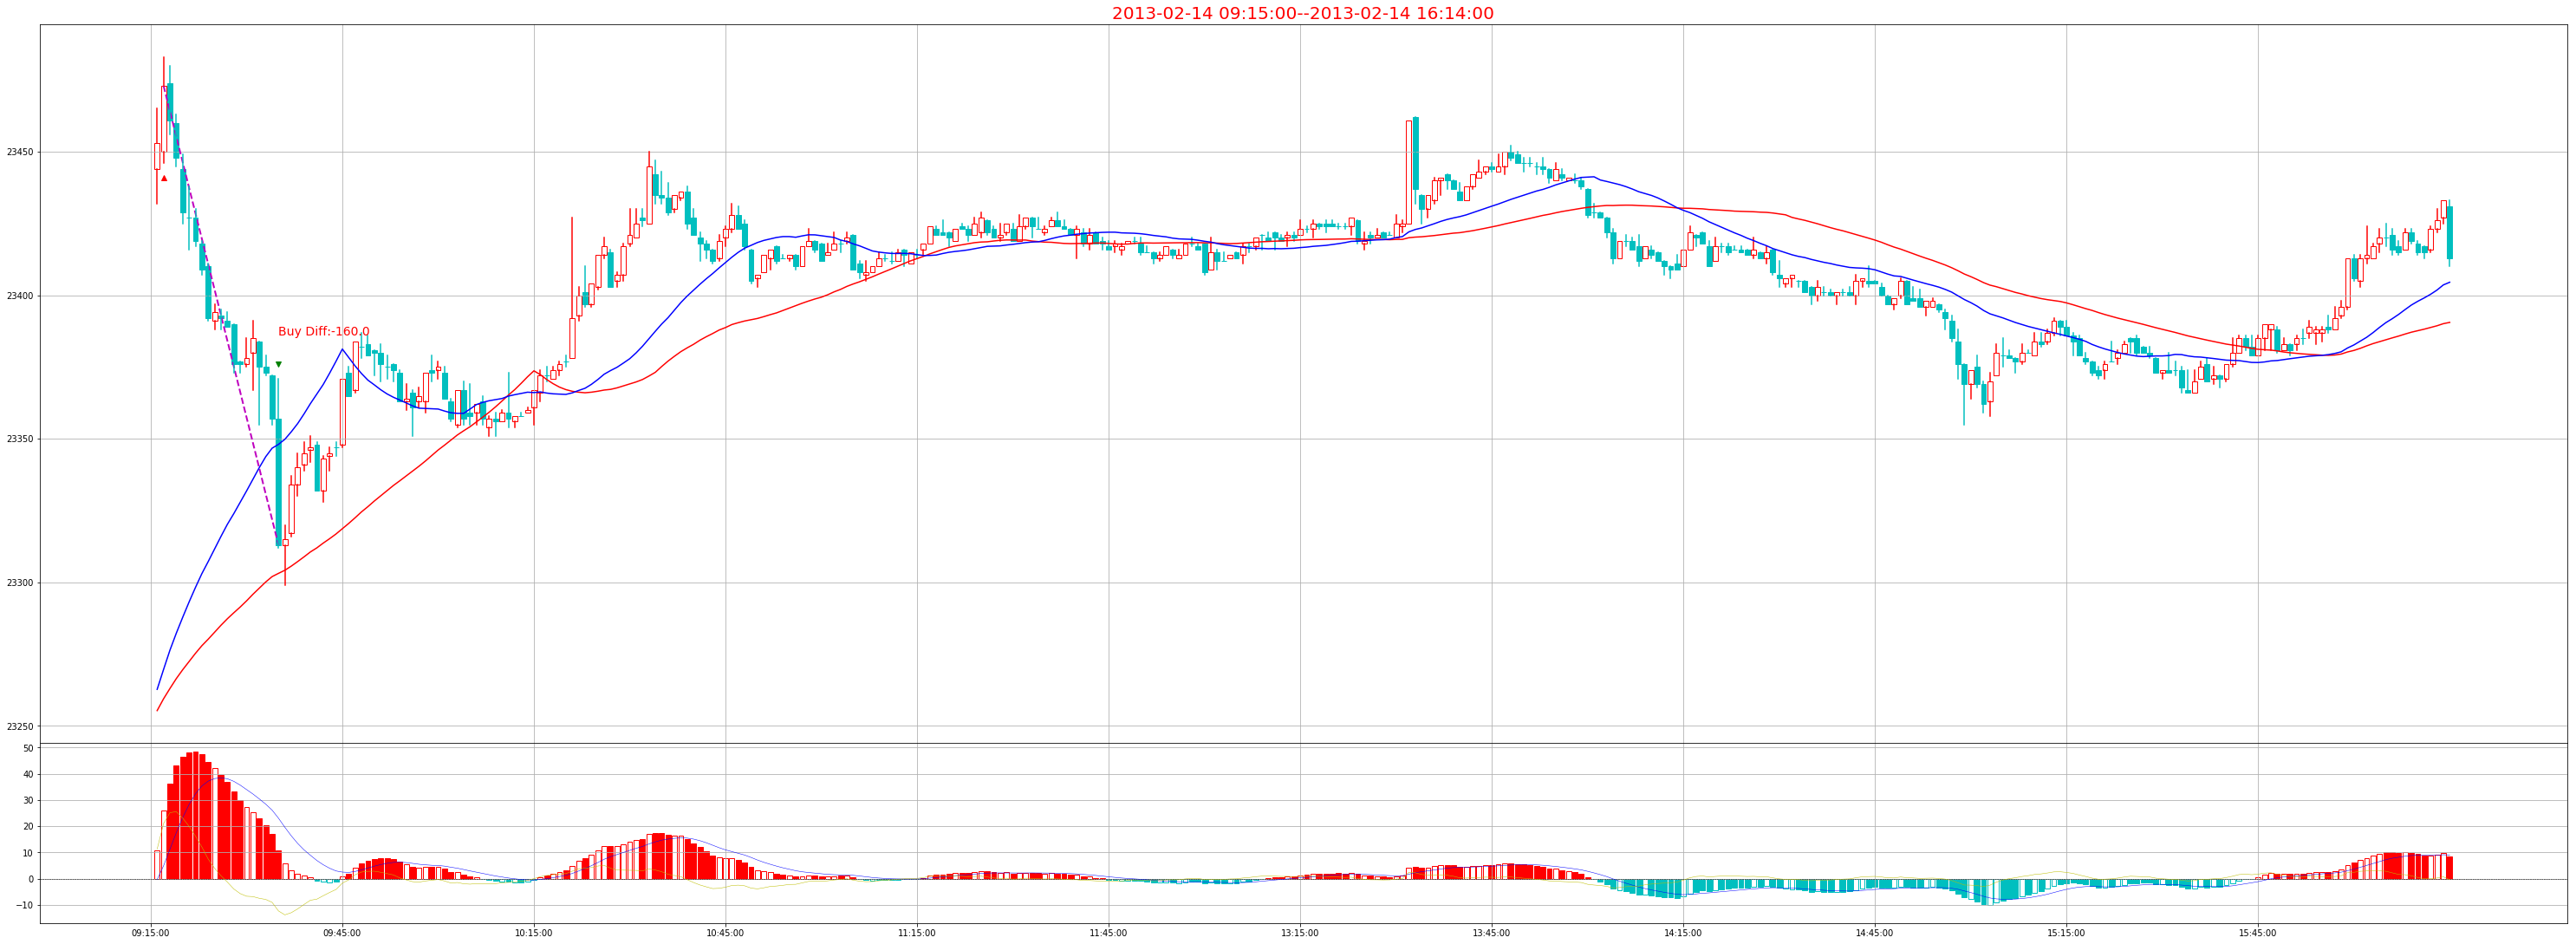

In [22]:
KL('HSI1302','2013-02-14',trade=('buy',1,19))

In [7]:
#2011-10-07 20170406
for i ,row in t1.sort_values('diff').head(5).iterrows():
    prod=row['prod']
    date=str(row['date'].date())
    day_no=row['open_idx']
    end_idx=row['close_idx']
    chg=row['diff']
    if chg>0:
        file="img/std2_%s_%d_%s.jpg" %(date,i,chg)
    else:
        file="img/std2_%s_%d_a%s.jpg" %(date,i,-chg)
    print(prod,date,file,day_no,end_idx)
    KL(prod,date,trade=['sell',day_no,end_idx])


KeyError: 'diff'

In [45]:
for i in range(8,15):
    print(i)

8
9
10
11
12
13
14
